<div align="center" style="color:powderblue; background-color:#2e2e2e; padding:20px; border-radius:10px;">

# Aprendizaje Profundo

### Grado en Ciencia de Datos

**Universidad Internacional de la Rioja (UNIR)**  
**Profesor:** Xuan González  
**Curso:** 2024-2025


**Tema 4: Redes neuronales recurrentes**

**Schedulers: técnicas de modificación de la tasa de aprendizaje**

---

</div>

# Schedulers

En este cuaderno vamos a probar diferentes schedulers para entrenar una red neuronal.

- Dataset: Utilizaremos el dataset MNIST por comodidad.

- Modelo: Vamos a entrenar un MLP para clasificar las cifras de MNIST. Para ello hará falta aplanar las imágenes y hacer un MLP donde el número de neuronas de la capa de input coincida con el número de píxeles de las imágenes de MNIST.

## Optimizadores

Este ejercicio comparará las curvas de entrenamiento de 5 casos diferentes:

1) SGD con mini-batches con tasa de aprendizaje constante.
2) AdaGrad
3) RMSprop
4) AdaDelta
5) Adam

### Dataset

Comenzaremos definiendo el dataset

In [1]:
# Importar las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# Transformaciones para convertir las imágenes a tensores y normalizarlas
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Cargar los conjuntos de entrenamiento y prueba
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Crear los loaders de datos
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)


### Definimos el MLP

In [2]:
# Definir el modelo MLP
class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_sizes=[128, 64], num_classes=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], num_classes)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

### Función de entrenamiento

Definimos la función de entrenamiento que llamaremos para cada uno de los modelos que vamos a entrenar con los diferentes schedulers.

In [3]:
# Función de entrenamiento
def train_model(model, optimizer, criterion, train_loader, test_loader, epochs):
    train_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        average_loss = running_loss / len(train_loader)
        train_losses.append(average_loss)
        
        # Evaluar en el conjunto de prueba
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        
        print(f'Época {epoch+1}/{epochs}, Pérdida: {average_loss:.4f}, Precisión: {accuracy:.2f}%')
    
    return train_losses, test_accuracies

## Optimizador 1: SGD con tasa de aprendizaje constante

El algoritmo de SGD (Stochastic Gradient Descent) actualiza los parámetros en la dirección negativa del gradiente de la función de pérdida respecto a los parámetros.

Fórmula de actualización:
$$
\theta_{t+1} = \theta_t - \eta \nabla J(\theta_t)
$$
Donde:
- $\theta_t$ son los parámetros en el paso t.
- $\eta$ es la tasa de aprendizaje (learning rate).
- $\nabla J(\theta_t)$ es el gradiente de la función de pérdida respecto a $\theta_t$.

In [4]:
# Configurar el modelo, criterio y optimizador
model_sgd = MLP()
criterion = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)

# Entrenar el modelo
epochs = 10
print('Entrenando con SGD con tasa de aprendizaje constante...')
losses_sgd, accuracies_sgd = train_model(model_sgd, optimizer_sgd, criterion, train_loader, test_loader, epochs)

Entrenando con SGD con tasa de aprendizaje constante...
Época 1/10, Pérdida: 0.8087, Precisión: 90.52%
Época 2/10, Pérdida: 0.3168, Precisión: 91.99%
Época 3/10, Pérdida: 0.2626, Precisión: 93.45%
Época 4/10, Pérdida: 0.2252, Precisión: 94.00%
Época 5/10, Pérdida: 0.1966, Precisión: 94.72%
Época 6/10, Pérdida: 0.1740, Precisión: 95.26%
Época 7/10, Pérdida: 0.1556, Precisión: 95.63%
Época 8/10, Pérdida: 0.1407, Precisión: 95.82%
Época 9/10, Pérdida: 0.1279, Precisión: 96.24%
Época 10/10, Pérdida: 0.1171, Precisión: 96.30%


## Optimizador 2: AdaGrad

AdaGrad (Adaptive Gradient) adapta la tasa de aprendizaje para cada parámetro individual en función de los gradientes pasados.

Fórmula de actualización:
$$
g_t = \nabla J(\theta_t)
$$
$$
G_t = G_{t-1} + g_t \odot g_t
$$
$$
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \odot g_t
$$
Donde:
- $G_t$ es la suma acumulada de los cuadrados de los gradientes.
- $\odot$ denota multiplicación elemento a elemento.
- $\epsilon$ es un pequeño valor para evitar división por cero.



In [5]:
# Configurar el modelo, criterio y optimizador
model_adagrad = MLP()
optimizer_adagrad = optim.Adagrad(model_adagrad.parameters(), lr=0.01)

# Entrenar el modelo
print('Entrenando con AdaGrad...')
losses_adagrad, accuracies_adagrad = train_model(model_adagrad, optimizer_adagrad, criterion, train_loader, test_loader, epochs)

Entrenando con AdaGrad...
Época 1/10, Pérdida: 0.2387, Precisión: 95.61%
Época 2/10, Pérdida: 0.1199, Precisión: 96.73%
Época 3/10, Pérdida: 0.0925, Precisión: 97.09%
Época 4/10, Pérdida: 0.0766, Precisión: 97.13%
Época 5/10, Pérdida: 0.0662, Precisión: 97.35%
Época 6/10, Pérdida: 0.0584, Precisión: 97.60%
Época 7/10, Pérdida: 0.0523, Precisión: 97.54%
Época 8/10, Pérdida: 0.0473, Precisión: 97.70%
Época 9/10, Pérdida: 0.0432, Precisión: 97.84%
Época 10/10, Pérdida: 0.0395, Precisión: 97.86%


## Optimizador 3: RMSprop

RMSprop (Root Mean Square Propagation) mantiene un promedio móvil de los cuadrados de los gradientes, permitiendo que el algoritmo reaccione más rápidamente a los cambios recientes.

Fórmula de actualización:
$$
g_t = \nabla J(\theta_t)
$$
$$
E[g^2]_t = \gamma E[g^2]_{t-1} + (1 - \gamma) g_t^2
$$
$$
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_t
$$
Donde:
- $E[g^2]_t$ es el promedio móvil de los cuadrados de los gradientes.
- $\gamma$ es el factor de decaimiento (decay rate), comúnmente 0.9.
- $\epsilon$ es un pequeño valor para estabilidad numérica.

In [6]:
# Configurar el modelo, criterio y optimizador
model_rmsprop = MLP()
optimizer_rmsprop = optim.RMSprop(model_rmsprop.parameters(), lr=0.01)

# Entrenar el modelo
print('Entrenando con RMSprop...')
losses_rmsprop, accuracies_rmsprop = train_model(model_rmsprop, optimizer_rmsprop, criterion, train_loader, test_loader, epochs)

Entrenando con RMSprop...
Época 1/10, Pérdida: 0.6204, Precisión: 93.66%
Época 2/10, Pérdida: 0.2276, Precisión: 95.03%
Época 3/10, Pérdida: 0.2038, Precisión: 95.05%
Época 4/10, Pérdida: 0.1868, Precisión: 95.20%
Época 5/10, Pérdida: 0.1719, Precisión: 95.22%
Época 6/10, Pérdida: 0.1722, Precisión: 95.44%
Época 7/10, Pérdida: 0.1641, Precisión: 95.77%
Época 8/10, Pérdida: 0.1611, Precisión: 94.65%
Época 9/10, Pérdida: 0.1609, Precisión: 95.64%
Época 10/10, Pérdida: 0.1656, Precisión: 95.60%


## Optimizador 4: AdaDelta

AdaDelta es una extensión de AdaGrad que busca reducir la disminución agresiva de la tasa de aprendizaje. En lugar de acumular todos los gradientes pasados, AdaDelta acumula un promedio exponencial de los cuadrados de los gradientes y también un promedio exponencial de los cuadrados de las actualizaciones de parámetros.

Fórmula de actualización:
$$
E[g^2]_t = \rho E[g^2]_{t-1} + (1 - \rho) g_t^2
$$
$$
\Delta \theta_t = - \frac{\sqrt{E[\Delta \theta^2]_{t-1} + \epsilon}}{\sqrt{E[g^2]_t + \epsilon}} g_t
$$
$$
E[\Delta \theta^2]_t = \rho E[\Delta \theta^2]_{t-1} + (1 - \rho) (\Delta \theta_t)^2
$$
$$
\theta_{t+1} = \theta_t + \Delta \theta_t
$$
Donde:
- $E[g^2]_t$ es el promedio móvil de los cuadrados de los gradientes.
- $E[\Delta \theta^2]_t$ es el promedio móvil de los cuadrados de las actualizaciones.
- $\rho$ es el factor de decaimiento, típicamente 0.9.
- $\epsilon$ es un término pequeño para estabilidad numérica.

In [7]:
# Configurar el modelo, criterio y optimizador
model_adadelta = MLP()
optimizer_adadelta = optim.Adadelta(model_adadelta.parameters())

# Entrenar el modelo
print('Entrenando con AdaDelta...')
losses_adadelta, accuracies_adadelta = train_model(model_adadelta, optimizer_adadelta, criterion, train_loader, test_loader, epochs)

Entrenando con AdaDelta...
Época 1/10, Pérdida: 0.2271, Precisión: 95.70%
Época 2/10, Pérdida: 0.0936, Precisión: 95.77%
Época 3/10, Pérdida: 0.0651, Precisión: 97.20%
Época 4/10, Pérdida: 0.0494, Precisión: 97.50%
Época 5/10, Pérdida: 0.0404, Precisión: 97.62%
Época 6/10, Pérdida: 0.0321, Precisión: 97.80%
Época 7/10, Pérdida: 0.0256, Precisión: 97.94%
Época 8/10, Pérdida: 0.0201, Precisión: 97.74%
Época 9/10, Pérdida: 0.0172, Precisión: 97.58%
Época 10/10, Pérdida: 0.0139, Precisión: 97.77%


## Optimizador 5: Adam

Adam (Adaptive Moment Estimation) combina las ideas de AdaGrad y RMSprop, manteniendo un promedio móvil de los gradientes y de los cuadrados de los gradientes, y ajustando los parámetros de manera adaptativa.

Fórmulas de actualización:
$$
g_t = \nabla J(\theta_t)
$$
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t^2
$$
$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t
$$
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}
$$
$$
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$
$$
\theta_{t+1} = \theta_t - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$
Donde:
- $v_t$ es el promedio móvil de los gradientes (momentum).
- $m_t$ es el promedio móvil de los cuadrados de los gradientes.
- $\beta_1$ y $\beta_2$ son los factores de decaimiento para $m_t$ y $v_t$, típicamente 0.9 y 0.999.
- $\hat{m}_t$ y $\hat{v}_t$ son las estimaciones corregidas de sesgo.
- $\epsilon$ es un término pequeño para estabilidad numérica.

In [8]:
# Configurar el modelo, criterio y optimizador
model_adam = MLP()
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)

# Entrenar el modelo
print('Entrenando con Adam...')
losses_adam, accuracies_adam = train_model(model_adam, optimizer_adam, criterion, train_loader, test_loader, epochs)

Entrenando con Adam...
Época 1/10, Pérdida: 0.2712, Precisión: 95.70%
Época 2/10, Pérdida: 0.1183, Precisión: 96.84%
Época 3/10, Pérdida: 0.0841, Precisión: 97.33%
Época 4/10, Pérdida: 0.0636, Precisión: 97.17%
Época 5/10, Pérdida: 0.0507, Precisión: 97.88%
Época 6/10, Pérdida: 0.0409, Precisión: 97.57%
Época 7/10, Pérdida: 0.0363, Precisión: 97.84%
Época 8/10, Pérdida: 0.0311, Precisión: 97.95%
Época 9/10, Pérdida: 0.0248, Precisión: 97.79%
Época 10/10, Pérdida: 0.0237, Precisión: 97.38%


## Comparación de curvas de entrenamiento

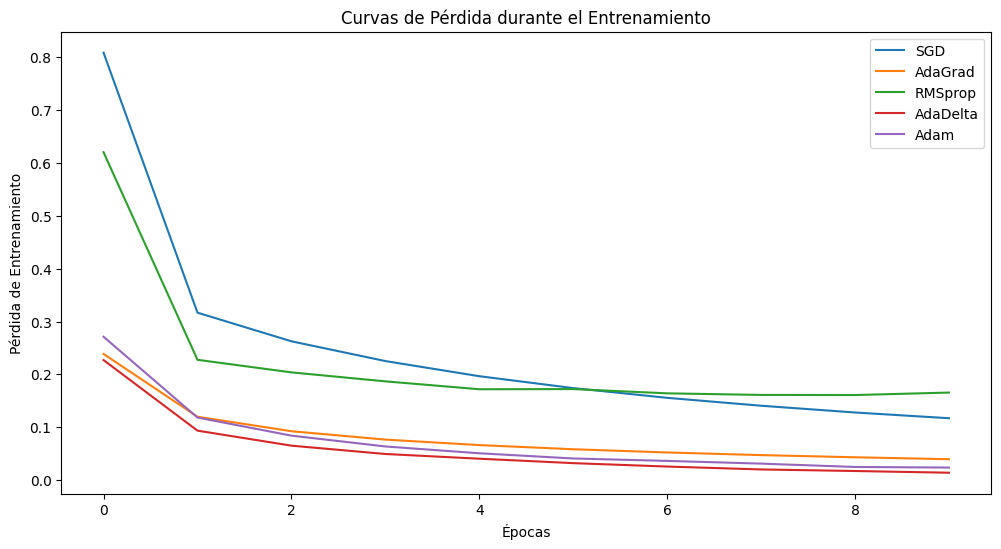

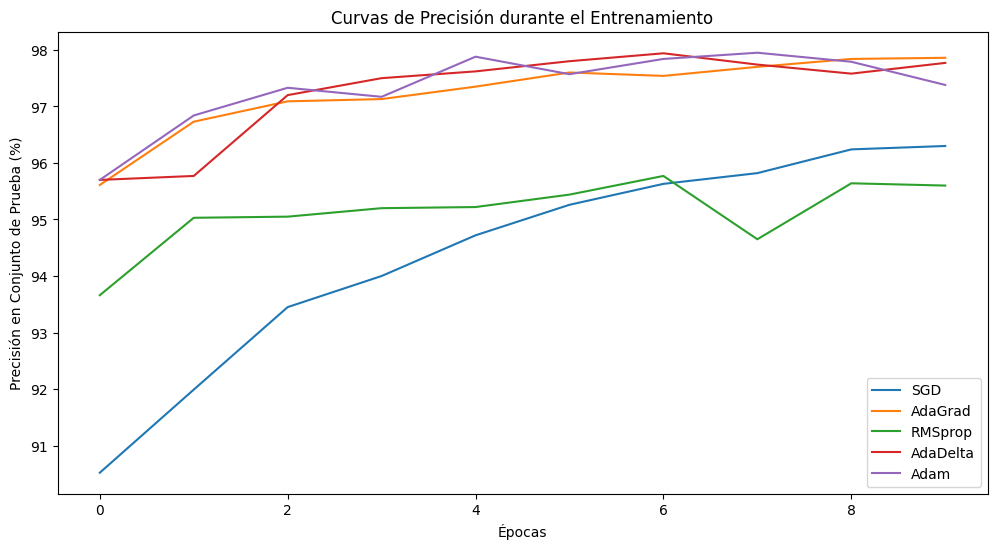

In [9]:
# Graficar las curvas de pérdida durante el entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(losses_sgd, label='SGD')
plt.plot(losses_adagrad, label='AdaGrad')
plt.plot(losses_rmsprop, label='RMSprop')
plt.plot(losses_adadelta, label='AdaDelta')
plt.plot(losses_adam, label='Adam')
plt.xlabel('Épocas')
plt.ylabel('Pérdida de Entrenamiento')
plt.title('Curvas de Pérdida durante el Entrenamiento')
plt.legend()
plt.show()

# Graficar las curvas de precisión durante el entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(accuracies_sgd, label='SGD')
plt.plot(accuracies_adagrad, label='AdaGrad')
plt.plot(accuracies_rmsprop, label='RMSprop')
plt.plot(accuracies_adadelta, label='AdaDelta')
plt.plot(accuracies_adam, label='Adam')
plt.xlabel('Épocas')
plt.ylabel('Precisión en Conjunto de Prueba (%)')
plt.title('Curvas de Precisión durante el Entrenamiento')
plt.legend()
plt.show()

## Conclusiones

En función de las curvas de entrenamiento, deberíamos sacar las siguientes conclusiones:

- SGD con tasa de aprendizaje constante: Puede ser lento para converger y sensible a la elección de la tasa de aprendizaje.
- AdaGrad: Se adapta bien a características escasas pero puede sufrir de una rápida disminución de la tasa de aprendizaje.
- RMSprop: Mantiene una tasa de aprendizaje efectiva más estable, lo que permite un entrenamiento más rápido.
- AdaDelta: Mejora sobre AdaGrad al evitar la disminución continua de la tasa de aprendizaje.
- Adam: Combina las ventajas de AdaGrad y RMSprop, adaptándose bien a diferentes problemas y es generalmente recomendado como optimizador por defecto.